<a href="https://colab.research.google.com/github/daaaanish17/Image-Classification/blob/main/Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Animal Classification using Transfer Learning Model (MobileNetV2)*

Image Dataset Link: https://www.kaggle.com/datasets/alessiocorrado99/animals10

Importing Libraries

In [10]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input 
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator , img_to_array
import pickle
from tensorflow.keras.models import load_model 
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image

Creating function for Image Data Generator.

In [19]:
def img_data(dir_path, target_size, batch, class_lst, pre_processs):
  if pre_processs:
    generate_object = ImageDataGenerator(preprocessing_function=pre_processs)
  else:
    generate_object = ImageDataGenerator()
   
  return (generate_object.flow_from_directory(dir_path, target_size=target_size, batch_size=batch,  #using flow_from_directory because all of our data is saved in form of directories.
                                                      class_mode='categorical', classes=class_lst, shuffle=True)) 

In [20]:
train_data_gen = img_data('./data/train', (224, 224), 32, os.listdir('./data/train'), preprocess_input)
# mobilenet. preprocess_input will scale input pixels between -1 and 1. input_shape: Optional shape tuple, 
# only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) 
# (with channels_last data format) or (3, 224, 224) (with channels_first data format).

valid_data_gen = img_data('./data/validation', (224, 224), 32, os.listdir('./data/validation'), preprocess_input)
test_data_gen = img_data('./data/test', (224, 224), 32, os.listdir('./data/test'), preprocess_input)

Found 2400 images belonging to 6 classes.
Found 981 images belonging to 6 classes.
Found 981 images belonging to 6 classes.


Transfer Learning With MobileNet V2. MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. *We will use this as our base model* to train with our dataset and classify the images of animals

In [21]:
base_model = ResNet50(
    include_top=False,  # Exclude the fully connected layers at the top
    weights='imagenet',  # Use pre-trained weights from ImageNet
    input_shape=(224, 224, 3)  # Define the input shape (height, width, channels)
)


Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [22]:
base_model.trainable=False

Creating our Image Classification Model

In [23]:
# model = tf.keras.models.Sequential()
# model.add(base_model)
# model.add(GlobalAvgPool2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(6, activation='softmax'))

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce the dimensionality
x = Dense(1024, activation='softmax')(x)
x = Dense(6, activation='softmax')(x)  # Replace 6 with the number of classes in your dataset
model = Model(inputs=base_model.input, outputs=x)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# This callback will stop the training when there is no improvement in # the loss for three consecutive epochs.

elst = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [27]:
# ModelCheckpoint callback allows you to continually save the model both during and at the end of training. 
# Model will saved in our drive ('MyDrive/animal_classification')

save_ck = callbacks.ModelCheckpoint('./models/resnet50.keras', save_best_only=True, monitor='val_loss', mode='min') 

In [28]:
history = model.fit(train_data_gen, batch_size=32, validation_data=valid_data_gen, callbacks=[elst, save_ck], epochs=10)

Epoch 1/10


C:\Users\DC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7727 - loss: 1.7231 - val_accuracy: 0.9776 - val_loss: 1.5807
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9869 - loss: 1.5403 - val_accuracy: 0.9796 - val_loss: 1.4493
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9941 - loss: 1.4081 - val_accuracy: 0.9806 - val_loss: 1.3367
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9952 - loss: 1.2955 - val_accuracy: 0.9817 - val_loss: 1.2360
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9978 - loss: 1.1917 - val_accuracy: 0.9817 - val_loss: 1.1424
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9953 - loss: 1.1012 - val_accuracy: 0.9817 - val_loss: 1.0550
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9951 - loss: 1.0156 - val_accuracy: 0.9817 - val_loss: 0.9744
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9971 - loss: 0.9342 - val_accuracy: 0.9827 - val_loss: 0.

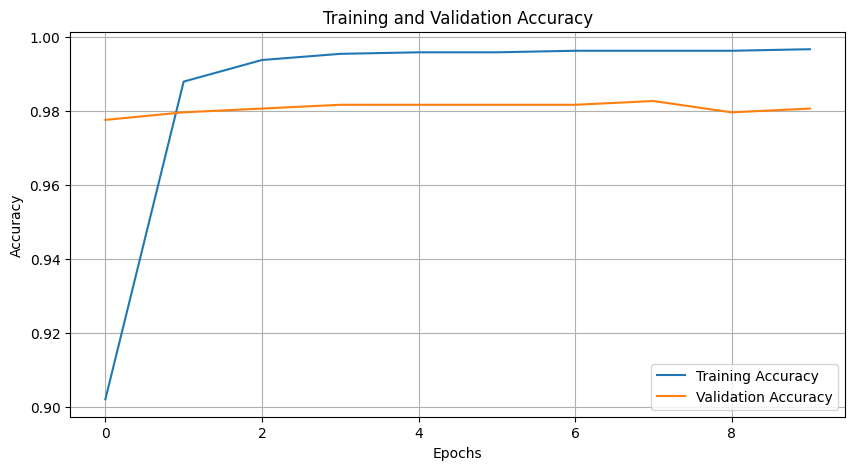

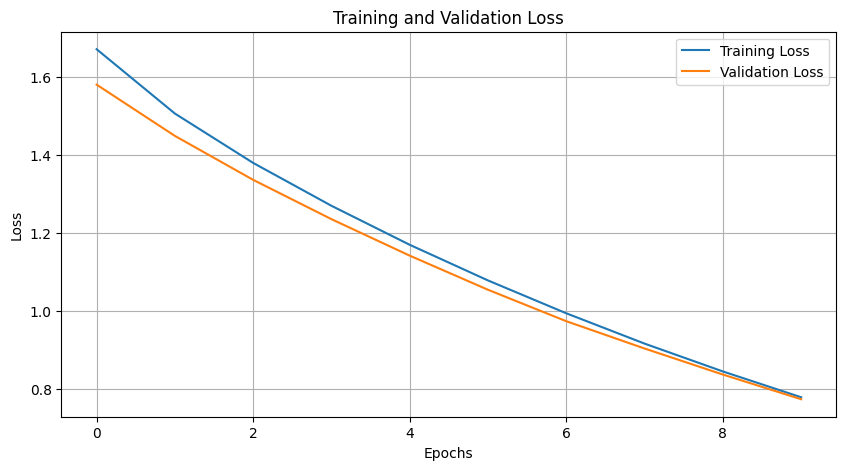

In [37]:
 # Plot the accuracy curve
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Save the accuracy plot
plt.savefig('./models/accuracy_curve_restnet_50.png')

# Show the plot
plt.show()

# Plot the loss curve
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the loss plot
plt.savefig('./models/loss_curve_resnet50.png')

# Show the plot
plt.show()

In [38]:
with open('./history_resnet50.p' , 'wb') as handle:
    pickle.dump(history.history , handle)

model.save('./models/resnet50.keras')

In [17]:
model = load_model('./models/resnet50.keras')

C:\Users\DC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 434 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [8]:
decode_dict = {0 : 'cat' , 1 : 'cow' , 2 : 'dog' , 3 : 'hen' , 4 : 'snake' , 5 : 'squirrel'}

In [31]:
# Load the image
img_path = './download.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input shape of the model (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (same as during model training)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# For ResNet50, you can decode the predictions (if using pretrained ImageNet classes)
# decoded_predictions = decode_predictions(predictions, top=3)[0]
# print("Predicted:", decoded_predictions)

# If you have custom classes, you'll need to decode the predictions manually
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted class: [4]


In [33]:
print(decode_dict[predicted_class[0]])

snake


In [36]:
pip install bing-image-downloader


Note: you may need to restart the kernel to use updated packages.


In [2]:
from bing_image_downloader import downloader

# Define the list of animals and number of images to download
animals = ["cat", "cow", "dog", "hen", "snake", "squirrel"]
num_images = 50

# Loop through each animal and download images
for animal in animals:
    downloader.download(animal, limit=num_images, output_dir='./data/new_test', adult_filter_off=True, force_replace=False, timeout=60)


[%] Downloading Images to D:\Ronak\Python\amimal_classification\Animal-Detector\data\new_test\cat


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://get.pxhere.com/photo/animal-pet-kitten-cat-small-mammal-fauna-heal-blue-eye-close-up-nose-whiskers-vertebrate-domestic-lying-tabby-cat-norwegian-forest-cat-ginger-fur-small-to-medium-sized-cats-cat-like-mammal-carnivoran-domestic-short-haired-cat-domestic-long-haired-cat-609263.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://www.photos-public-domain.com/wp-content/uploads/2017/12/gray-cat-with-green-eyes.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://upload.wikimedia.org/wikipedia/commons/d/d4/Cat_March_2010-1a.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://upload.wikimedia.org/wikipedia/commons/c/c4/Savannah_Cat_portrait.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://www.baltana.com/files/wallpapers-2/Cute-Cat-Images-07756.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
0
1/1 ━━━━━━━━━━━━

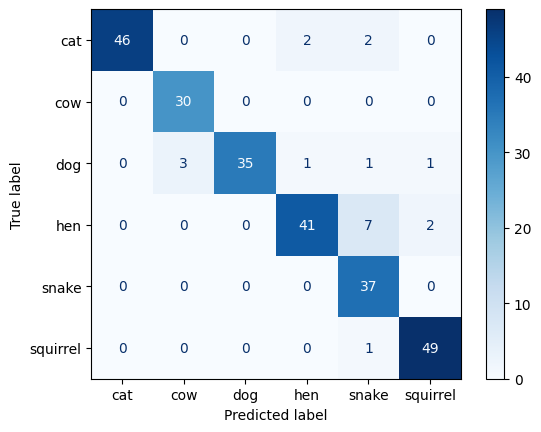

              precision    recall  f1-score   support

         cat       1.00      0.92      0.96        50
         cow       0.91      1.00      0.95        30
         dog       1.00      0.85      0.92        41
         hen       0.93      0.82      0.87        50
       snake       0.77      1.00      0.87        37
    squirrel       0.94      0.98      0.96        50

    accuracy                           0.92       258
   macro avg       0.93      0.93      0.92       258
weighted avg       0.93      0.92      0.92       258



<Figure size 640x480 with 0 Axes>

In [36]:
# Define image directory and labels
image_dir = './data/new_test'  # Update this to your dataset folder path
classes = ['cat', 'cow', 'dog', 'hen', 'snake', 'squirrel']
image_size = (224, 224)  # Adjust according to the model input size


# Initialize lists to store true and predicted labels
y_true = []
y_pred = []
count = 0

# Loop through each class folder
for label in classes:
    class_dir = os.path.join(image_dir, label)
    for image_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        
        # Convert the image to a numpy array
        img_array = image.img_to_array(img)
        
        # Expand dimensions to match the input shape of the model (batch_size, height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Preprocess the image (same as during model training)
        img_array = preprocess_input(img_array)
        
        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        
        # Append true and predicted labels
        y_true.append(count)
        y_pred.append(predicted_class)

    count = count + 1

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Save the confusion matrix plot
plt.savefig('confusion_matrix.png')